# Классификация изображений

### Установка зависимостей

In [1]:
!pip install -U torch torchvision
!pip install --upgrade pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 10.5 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0


In [2]:
!nvidia-smi
import torch
torch.cuda.is_available()
torch.cuda.empty_cache()

Mon Sep  4 21:05:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

Mounted at /content/gdrive/


In [4]:
import pickle
import numpy as np
from skimage import io
import pandas as pd
import torch

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, models, datasets
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import lr_scheduler

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

# ---------------- оставляем изначальный класс ----------------

class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

def fit_epoch(model, train_loader, criterion, optimizer): #!!!Не хочу собирать информацию во время обучения
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs, aux_outputs = model(inputs)
        loss = criterion(outputs, labels) + 0.3 * criterion(aux_outputs, labels)
        loss.backward()
        optimizer.step()

def eval_epoch(model, val_loader, criterion): #!!!Возвращаю значение f1_score для отслеживания лучшего результата
    model.eval()
    running_loss = 0.0
    processed_size = 0

    total_outputs, total_labels = [], []
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        processed_size += inputs.size(0)

        total_outputs = np.hstack((total_outputs, preds.cpu().numpy()))
        total_labels = np.hstack((total_labels, labels.cpu().numpy()))

    val_loss = running_loss / processed_size
    val_f1 = f1_score(total_labels, total_outputs, average='micro')
    return val_loss, val_f1

def predict(model, test_loader):
    model.eval()
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

def prepare_model(layer_to_freeze = 5): #!!!Здесь я подготавливаю модели
    m1 = models.inception_v3(pretrained=True)
    for name, module in m1.named_children():
        if name in ['Conv2d_1a_3x3', 'Conv2d_2a_3x3', 'Conv2d_2b_3x3', 'Conv2d_3b_1x1', 'Conv2d_4a_3x3']:
            for sub_name, sub_module in module.named_children():
                if isinstance(sub_module, nn.Conv2d):
                    sub_module.padding = (4, 4) #!!!Без добавления паддинга на внутренних слоях изображения будут меньше ядер свёртки
    for i, child in enumerate(m1.children()): #!!!Заморозим первые слои для ускорения обучения
        if i < layer_to_freeze:
            for param in child.parameters():
                param.requires_grad = False
    num_features = m1.AuxLogits.fc.in_features #!!!Замораживать первые слои нельзя, потому что мы немного изменили их
    m1.AuxLogits.fc = torch.nn.Linear(num_features, 42) #!!!Здесь меняю последние слои в соответствии с задачей
    opt1 = torch.optim.Adam(list(m1.parameters())[layer_to_freeze:], lr=3e-3) #!!!Inception3 использует батчнормализацию, поэтому используем высокий lr

    #for name, layer in m1.named_children():
    #    print(name, layer)

#    m2 = models.vgg16_bn(pretrained=True) #!!!Попробуем vgg с батч-нормализацией
#    num_features = m2.classifier[-1].in_features
#    m2.classifier[-1] = torch.nn.Linear(num_features, 42)
#    for i, child in enumerate(m2.children()): #!!!Заморозим первые слои, потому что нет надобности в их обучении
#        if i < layer_to_freeze:
#            for param in child.parameters():
#                param.requires_grad = False
#    opt2 = torch.optim.Adam(params=[
#        {"params": m2.classifier.parameters()},
#        {"params": list(m2.features.parameters())[layer_to_freeze:], "lr": 3e-4,} #!!!Применим технику обучения модели разными lr
#        ], lr=1e-3) #!!!Эта модель с батчнормами, поэтому применяю lr выше на порядок для выходного слоя

    return m1, opt1

def train(train_dataset, val_dataset, model, optimizer, epochs=10, batch_size=64):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    log_template = "\nEpoch {ep:03d} val_loss {v_loss:0.4f} val_f1 {v_f1:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        criterion = nn.CrossEntropyLoss()
        scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)#!!!Меняю lr каждые 7 эпох
        for epoch in range(epochs):
            fit_epoch(model, train_loader, criterion, optimizer)
            scheduler.step() #!!!Не забываем сделать шаг для обновления lr

            val_loss, val_f1 = eval_epoch(model, val_loader, criterion)

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, v_loss=val_loss, v_f1=val_f1))

    torch.save(model.state_dict(), 'my_best_model.pth')
    return model

In [5]:
TRAIN_DIR = Path('train/simpsons_dataset')
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))

from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')

prepared_model, opt = prepare_model(layer_to_freeze = 10) #!!!C 20 замороженными слоями получился f1=0.61 за 30 минут
best_model = train(train_dataset, val_dataset, model=prepared_model.to(DEVICE), optimizer=opt, epochs=15, batch_size=64)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 70.3MB/s]
epoch:   7%|▋         | 1/15 [03:12<44:53, 192.39s/it]


Epoch 001 val_loss 0.7595 val_f1 0.8057


epoch:  13%|█▎        | 2/15 [06:14<40:25, 186.54s/it]


Epoch 002 val_loss 0.3696 val_f1 0.9018


epoch:  20%|██        | 3/15 [09:24<37:34, 187.89s/it]


Epoch 003 val_loss 0.4889 val_f1 0.8758


epoch:  27%|██▋       | 4/15 [12:29<34:13, 186.65s/it]


Epoch 004 val_loss 0.4721 val_f1 0.8972


epoch:  33%|███▎      | 5/15 [15:32<30:53, 185.32s/it]


Epoch 005 val_loss 0.3312 val_f1 0.9163


epoch:  40%|████      | 6/15 [18:33<27:36, 184.04s/it]


Epoch 006 val_loss 0.4361 val_f1 0.9005


epoch:  47%|████▋     | 7/15 [21:36<24:28, 183.55s/it]


Epoch 007 val_loss 0.2788 val_f1 0.9329


epoch:  53%|█████▎    | 8/15 [24:38<21:21, 183.12s/it]


Epoch 008 val_loss 0.1808 val_f1 0.9589


epoch:  60%|██████    | 9/15 [27:41<18:18, 183.06s/it]


Epoch 009 val_loss 0.1749 val_f1 0.9627


epoch:  67%|██████▋   | 10/15 [30:43<15:13, 182.78s/it]


Epoch 010 val_loss 0.1774 val_f1 0.9635


epoch:  73%|███████▎  | 11/15 [33:45<12:10, 182.70s/it]


Epoch 011 val_loss 0.1749 val_f1 0.9643


epoch:  80%|████████  | 12/15 [36:49<09:08, 182.98s/it]


Epoch 012 val_loss 0.1820 val_f1 0.9645


epoch:  87%|████████▋ | 13/15 [39:52<06:05, 182.83s/it]


Epoch 013 val_loss 0.1788 val_f1 0.9650


epoch:  93%|█████████▎| 14/15 [42:55<03:02, 182.87s/it]


Epoch 014 val_loss 0.1900 val_f1 0.9614


epoch: 100%|██████████| 15/15 [45:56<00:00, 183.78s/it]



Epoch 015 val_loss 0.1908 val_f1 0.9626


In [6]:
TEST_DIR = Path('testset/testset')
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64, num_workers=2)
#prepared_model.load_state_dict(torch.load('my_best_model.pth'))
probs = predict(best_model, test_loader)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))

test_filenames = [path.name for path in test_dataset.files]
pd.DataFrame({'Id': test_filenames, 'Expected': preds}).to_csv('/content/gdrive/MyDrive/simpsons/my_best_model.csv', index=False)

In [7]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [8]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

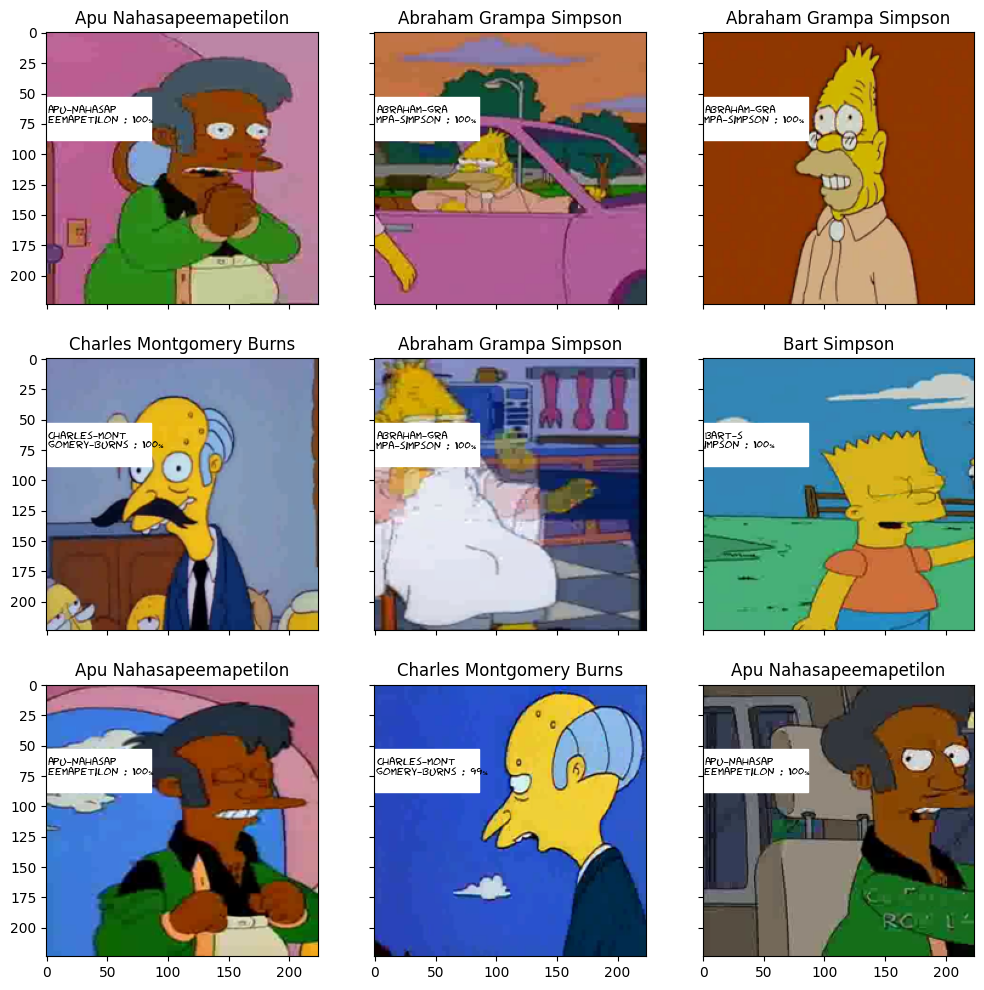

In [9]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(best_model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')